In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator
from textwrap import fill

import glob

import os

In [4]:
import sys
from pathlib import Path

repo_root = Path().resolve().parents[0]
sys.path.append(str(repo_root))

print("Added to sys.path:", repo_root)

from utils.common_functions import save_or_show, load_df


Added to sys.path: D:\Joe\1\Stufffs\Research\Mapping Future Skills in UK Engineering Education


# Deployment

In [ ]:
CUSTOM_CAH = ("10")
TITLE = "Trends in Engineering Enrolments in UK Higher Education (2019/2020 - 2023/2024)"
YLABEL = "Enrolments"
path = r"../data/table-46"

In [ ]:
df = load_df(path, skip_rows=22)

In [22]:
def publication_rc():
    plt.rcParams.update({
        "figure.figsize": (12, 6),
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "lines.linewidth": 1.0,
        "axes.titleweight": "bold",
        "axes.labelweight": "bold",
        "legend.frameon": False,
        "font.family": "DejaVu Sans",
    })

In [23]:
def keep_totals_slice(df):
    mask = (
        df["CAH level marker"].eq("CAH level 3") &
        df["Entrant marker"].eq("All") &
        df["Level of study"].eq("All") &
        df["Mode of study"].eq("All") &
        df["Permanent address marker"].eq("Total")
    )
    d = df.loc[mask].copy()
    return d

In [24]:

def filter_scope(d, custom=("10", "11", "13")):
    keep = d["CAH level subject"].str.startswith(custom, na=False)
    df_keep = d[keep].copy()
    return df_keep

In [25]:
def ensure_subject_label_has_no_code(d):
    if "Subject" not in d.columns:
        d["Subject"] = d["CAH level subject"].str.replace(
            r"^\s*\d{2}-\d{2}-\d{2}\s+", "", regex=True
        ).str.strip()
    return d

In [26]:
def build_pivot(d):
    pvt = d.pivot_table(index="Academic Year", columns="Subject",
                        values="Number", aggfunc="sum").fillna(0)
    order = (pvt.index.str.slice(0, 4).astype(int)).argsort()
    pvt = pvt.iloc[order]
    return pvt

In [27]:
def select_top_columns(pvt, top_n=8):
    latest_year = pvt.index.max()
    top_cols = pvt.loc[latest_year].sort_values(ascending=False).head(top_n).index
    pvt_top = pvt[top_cols].copy()
    return pvt_top

In [28]:
def plot_lines(pvt_top, title, ylabel, out_basename, chart_dir):

    publication_rc()
    fig, ax = plt.subplots(constrained_layout=True, figsize=(12,6))
    pvt_top.plot(ax=ax, lw=1.3)

    ax.set_title(fill(title, width=60), pad=25, fontweight="bold", fontsize=15)
    ax.title.set_wrap(True)

    ax.set_xlabel("Academic Year", labelpad=15, fontsize=12)
    ax.set_ylabel(ylabel, labelpad=12, fontsize=12)

    ax.yaxis.set_major_locator(MultipleLocator(5000))
    ax.yaxis.set_minor_locator(MultipleLocator(1000))
    ax.grid(True, which="both", axis="x", linestyle="--", alpha=0.5)
    ax.grid(True, which="major", axis="y", linestyle="--", alpha=0.5)
    ax.grid(True, which="minor", axis="y", linestyle=":",  alpha=0.2)

    for t in ax.get_yticklabels():
        t.set_rotation(30)
        t.set_ha("right")
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
   
    ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), frameon=False)

    fig.set_constrained_layout_pads(
        h_pad=0.10,  
        w_pad=0.05,  
        hspace=0.20, 
        wspace=0.02
    )

    save_or_show(fig, out_dir=chart_dir, filename=out_basename, show=True)

In [29]:
def filter(df_, cah, top_n: int | None = None):
    d = filter_scope(df_, custom=cah)
    d = ensure_subject_label_has_no_code(d)
    if top_n is None:
        TOP_N = d["Subject"].nunique()
    else:
        TOP_N = top_n
    pvt = build_pivot(d)
    pvt_top = select_top_columns(pvt, top_n=TOP_N)
    return pvt_top

In [30]:
df_keep = keep_totals_slice(df)

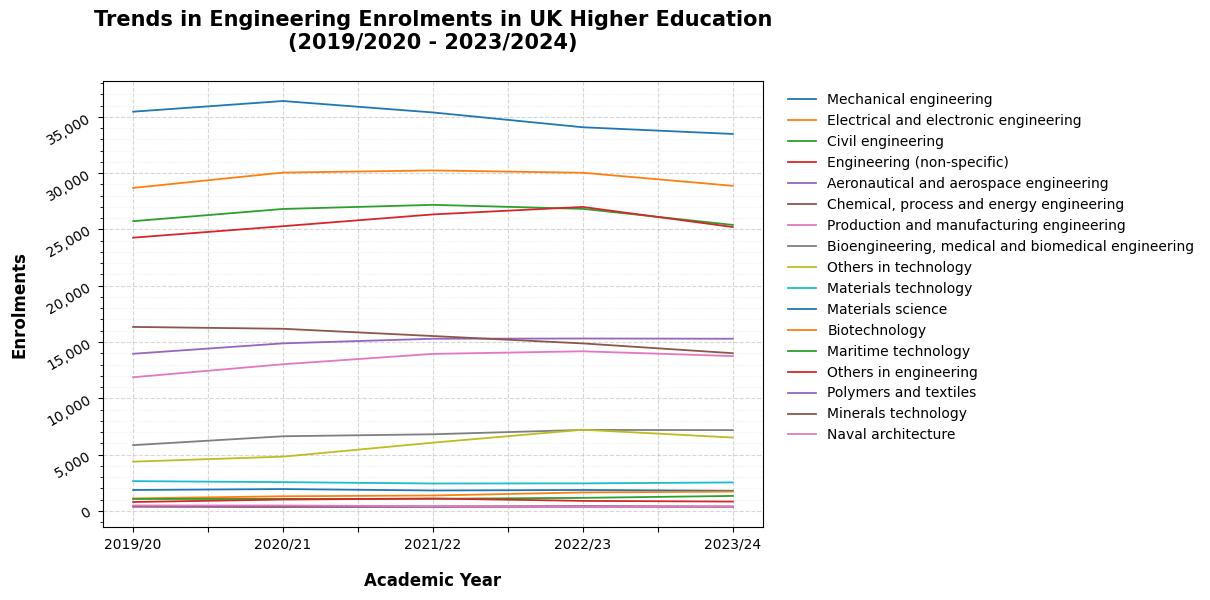

In [ ]:
pvt = filter(df_keep, cah=("10"))
plot_lines(pvt, 
           "Female Participation across Engineering Disciplines (2014/2015 to 2023/2024)",
            "Enrolments", 
            "all_eng_and_tech_students_lines", 
            chart_dir="chart-3")